# Comparing qubits
In this exercise we will show a real comparison between the different qubits in one of the machines.
We will run the same Bell state quantum program on three different setups:  
- an ideal quantum computer (qasm_simulator)
- the 'best' and the 'worst' qubit pair on a five qubit least busy IBM Q machine  

We will print and plot the end result to compare the ideal result (|00> and |11> at 50%) with the real results (A probabilistic mix of |00>, |01>, |10>, and |11>) to illustrate how today’s quantum computers still have a little way to go. 


Let's start by importing the IBMQ method and load our account.

In [1]:
from qiskit import QuantumCircuit, IBMQ, Aer,  ClassicalRegister, QuantumRegister, execute
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

IBMQ.load_account()
provider = IBMQ.get_provider()


Then, let's pick the least busy available backend for our exercise

In [2]:
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(operational=True, simulator=False))

print("Selected backend:",backend.status().backend_name)
print("Number of qubits(n_qubits):", backend.configuration().n_qubits)
print("Pending jobs:", backend.status().pending_jobs)

Selected backend: ibmqx2
Number of qubits(n_qubits): 5
Pending jobs: 4


Pull out the best and worst cx-gates performance information.

In [3]:
gates=backend.properties().gates

gate_type = "cx"
cx_best_worst = [[[0,0],1],[[0,0],0]]
for n in range (0, len(gates)):
    if gates[n].gate == gate_type:
        if gate_type == "cx":
            print(gates[n].name, ":", gates[n].parameters[0].name,"=", gates[n].parameters[0].value)
            if cx_best_worst[0][1]>gates[n].parameters[0].value:
                cx_best_worst[0][1]=gates[n].parameters[0].value
                cx_best_worst[0][0]=gates[n].qubits
            if cx_best_worst[1][1]<gates[n].parameters[0].value:
                cx_best_worst[1][1]=gates[n].parameters[0].value
                cx_best_worst[1][0]=gates[n].qubits
        else:
            print(gates[n].gate, gates[n].parameters[0].name,gates[n].parameters[0].value)

print("Best cx gate:", cx_best_worst[0][0], ",", round(cx_best_worst[0][1]*100,3),"%")
print("Worst cx gate:", cx_best_worst[1][0], ",", round(cx_best_worst[1][1]*100,3),"%")


cx0_1 : gate_error = 0.012372819579417965
cx0_2 : gate_error = 0.012967303843418293
cx1_0 : gate_error = 0.012372819579417965
cx1_2 : gate_error = 0.0135385321800571
cx2_0 : gate_error = 0.012967303843418293
cx2_1 : gate_error = 0.0135385321800571
cx2_3 : gate_error = 0.011817699107264462
cx2_4 : gate_error = 0.01192372247727344
cx3_2 : gate_error = 0.011817699107264462
cx3_4 : gate_error = 0.013936469562508796
cx4_2 : gate_error = 0.01192372247727344
cx4_3 : gate_error = 0.013936469562508796
Best cx gate: [2, 3] , 1.182 %
Worst cx gate: [3, 4] , 1.394 %


Create a quantum circuit for the selected backend.

In [4]:
q1 = QuantumRegister(backend.configuration().n_qubits)
c1 = ClassicalRegister(backend.configuration().n_qubits)
qc_best = QuantumCircuit(q1, c1)
qc_worst = QuantumCircuit(q1, c1)


Create the best Bell circuit for the backend.

Best CX:


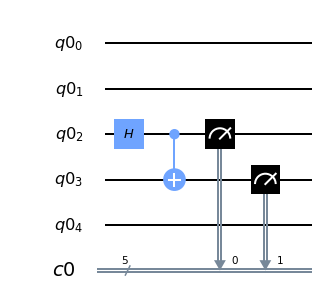

In [5]:
qc_best.h(q1[cx_best_worst[0][0][0]])
qc_best.cx(q1[cx_best_worst[0][0][0]], q1[cx_best_worst[0][0][1]])
qc_best.measure(q1[cx_best_worst[0][0][0]], c1[0])
qc_best.measure(q1[cx_best_worst[0][0][1]], c1[1])
print("Best CX:")
display(qc_best.draw(output="mpl"))



Create the worst Bell circuit for the backend.

Worst CX:


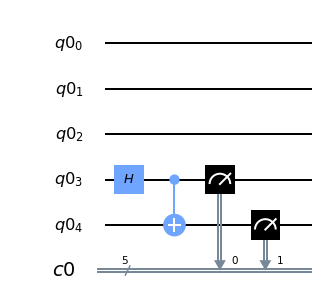

In [6]:
qc_worst.h(q1[cx_best_worst[1][0][0]])
qc_worst.cx(q1[cx_best_worst[1][0][0]], q1[cx_best_worst[1][0][1]])
qc_worst.measure(q1[cx_best_worst[1][0][0]], c1[0])
qc_worst.measure(q1[cx_best_worst[1][0][1]], c1[1])

print("Worst CX:")
display(qc_worst.draw(output="mpl"))


Run the best and worst circuits on backend.

In [7]:
job_best = execute(qc_best, backend, shots=1000)
job_monitor(job_best)
job_worst = execute(qc_worst, backend, shots=1000)
job_monitor(job_worst)

Job Status: job has successfully run
Job Status: job has successfully run


Run a benchmark Bell circuit on the simulator.

In [8]:
q = QuantumRegister(backend.configuration().n_qubits)
c = ClassicalRegister(backend.configuration().n_qubits)
qc = QuantumCircuit(q, c)

qc.h(q[0])
qc.cx(q[0], q[1])
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])

backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_sim)

Print the results for the best, worst, and baseline qubit pair.

In [9]:
best_result = job_best.result()
counts_best  = best_result.get_counts(qc_best)
print("Best qubit pair:")
print(counts_best)

worst_result = job_worst.result()
counts_worst  = worst_result.get_counts(qc_worst)
print("Worst qubit pair:")
print(counts_worst)

sim_result = job_sim.result()
counts_sim  = sim_result.get_counts(qc)
print("Simulated baseline:")
print(counts_sim)


Best qubit pair:
{'00001': 11, '00000': 452, '00010': 10, '00011': 527}
Worst qubit pair:
{'00001': 14, '00000': 519, '00010': 15, '00011': 452}
Simulated baseline:
{'00000': 526, '00011': 498}


Plot the results in a diagram.

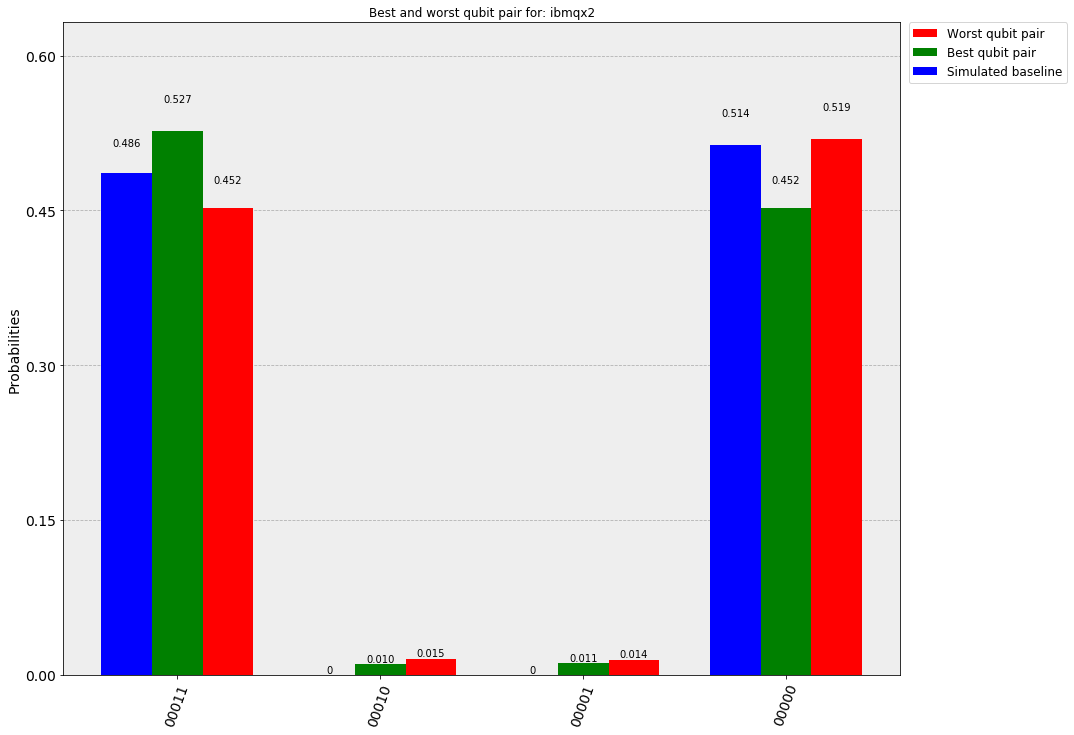

In [10]:
plot_histogram([counts_worst, counts_best, counts_sim],
  title = "Best and worst qubit pair for: " + backend.name(),
  legend     = ["Worst qubit pair","Best qubit pair","Simulated baseline"],             
  sort       = 'desc',
  figsize    = (15,12),
  color      = ['red','green', 'blue'],
  bar_labels = True)
